In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import seaborn
%matplotlib inline

## matplotlib settings
matplotlib.style.use('ggplot')
#plt.rcParams['figure.figsize']=16,10
plt.rcParams.update({'font.size': 12, 
                            'font.family': 'STIXGeneral', 
                            'mathtext.fontset': 'stix'})
# seaborn settings
seaborn.set_palette('deep', desat=.6)
np.random.seed(123456)

<b style= "font-size: 120%;">
Dataset
</b>

In [2]:
# reading data set
data= pd.read_csv('hard_drive_data_2015.csv')
data= data.drop('Unnamed: 0', 1)
data= data.sort_values(by='date')

<b style= "font-size: 120%;">
Failed and working disks:
</b>

In [3]:
fail= pd.DataFrame(data[data.failure==1]).reset_index()
fail= fail.drop('index', axis= 1)

In [4]:
success= data.groupby(['serial_number']).filter(lambda x: x['failure'].sum()==0) 
succ= pd.DataFrame(success.groupby(['serial_number']).tail(n=1)).reset_index()
succ= succ.drop('index', axis= 1)

In [5]:
disks= pd.concat([succ, fail], ignore_index=True) 

<b style= "font-size: 120%;">
Feature selection
</b>

In [6]:
cols= [c for c in disks.columns if (disks[c].dtype== np.dtype('O'))]
cols.append('failure')

In [7]:
X= disks.drop(cols, axis= 1)
y= disks.failure

In [8]:
# Build a forest and compute the feature importances
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [9]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

In [10]:
forest.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
imp_features= forest.feature_importances_
imp_features

array([  3.03000157e-02,   6.69683456e-02,   1.17213019e-01,
         6.20374970e-02,   3.12519465e-02,   4.82469191e-02,
         1.14061727e-01,   9.66115497e-02,   2.03172669e-01,
         2.20203469e-05,   1.04413368e-01,   6.27747822e-02,
         6.29261405e-02])

In [12]:
# each estimator has a feature importance
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

In [13]:
indices = np.argsort(imp_features)[::-1] # order of importance
indices

array([ 8,  2,  6, 10,  7,  1, 12, 11,  3,  5,  4,  0,  9])

In [14]:
colum_labels= np.array(['capacity_bytes', 'Read error rate (normalized)', 
 'Read error rate (raw)', 'spin-up time (normalized)',
 'spin-up time (raw)', 'Reallocated sectors counts (normalized)',
 'Reallocated sectors counts (raw)', 'Running time (normalized)',
 'Running time (raw)', 'Power cycle count (normalized)',
 'Power cycle count (raw)', 'Internal temperature (normalized)',
 'Internal temperature (raw)'])

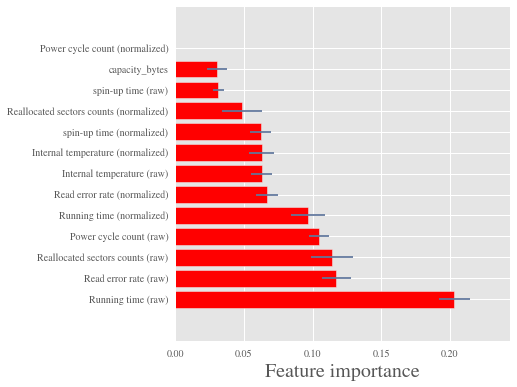

Feature ranking:
feature 8 (0.203173)
feature 2 (0.117213)
feature 6 (0.114062)
feature 10 (0.104413)
feature 7 (0.096612)
feature 1 (0.066968)
feature 12 (0.062926)
feature 11 (0.062775)
feature 3 (0.062037)
feature 5 (0.048247)
feature 4 (0.031252)
feature 0 (0.030300)
feature 9 (0.000022)


In [15]:
plt.figure(figsize= (6,6))

plt.barh(range(X.shape[1]), imp_features[indices],
       color="r", xerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
#plt.xlim([-1, X.shape[1]])
plt.xlim(0, 1.2*max(imp_features))
plt.yticks(range(X.shape[1]), colum_labels[indices])
plt.xlabel("Feature importance", fontsize=20)
plt.savefig('feature_selection.pdf', bbox_inches= 'tight')
plt.show()

# write these results in the final report
print("Feature ranking:")
for f in range(X.shape[1]):
    print("feature %d (%f)"%(indices[f], imp_features[indices[f]]))

In [16]:
# reduce X to the feature selection
model = SelectFromModel(forest, prefit=True)
X_new = pd.DataFrame(model.transform(X), columns= ['smart_1_raw', 'smart_5_raw',
                                                  'smart_9_normalized', 'smart_9_raw',
                                                  'smart_12_raw']  )
y_new= y

<b style= "font-size: 140%;">
Fraction of failed and working disks:<br>
(Unbalanced samples)
</b>

In [17]:
Xy_new= pd.concat([X_new, y_new], axis= 1) # this is the  first set to work with

In [26]:
Xy_new_fail= Xy_new[Xy_new.failure==1]
Xy_new_succ= Xy_new[Xy_new.failure== 0]
sd= len(Xy_new_succ)
fd= len(Xy_new_fail)
tot= sd+fd
print ('Fraction of failed disks:', np.round(fd/tot*100, 1), '%')
print ('Fraction of working disks:', np.round(sd/tot*100, 1), '%')

Fraction of failed disks: 2.3 %
Fraction of working disks: 97.7 %


<p style= "font-size: 120%;">
Clearly this is an unbalanced classification problem. This is solved by oversampling the minority class or by undersampling the majority class. I will use the new datasets: Xy_new_fail, Xy_new_succ .
</p>

<b style= "font-size: 140%;">
Oversampling:
</b>

The oversampling is done such that the percentages of the failed and working disks in the new sample will be 40% and 60% respectively.

In [27]:
# number of elements for the minority class (failed disks):
num_elements= int( (2./3)*sd)

In [28]:
failed_oversample= Xy_new_fail.sample(n= num_elements, replace=True, random_state= 123456)
succ_oversample=  Xy_new_succ.copy()

In [30]:
# percentages:
fd1= np.shape(failed_oversample)[0]
sd1= np.shape(succ_oversample)[0]
tot= (fd1+sd1)
print ('Fraction of failed disks after oversampling:', np.round((fd1/tot*100),1 ), '%')
print ('Fraction of working disks after oversampling:', np.round(sd1/tot*100,1), '%')

Fraction of failed disks after oversampling: 40.0 %
Fraction of working disks after oversampling: 60.0 %


<b style= "font-size: 140%;">
Subsampling:
</b>


In [32]:
int(sd/fd), fd #-> number of subsamples, elements in each subsample

(43, 1428)